### This notebook is contributed by Jihua Liu (Cloud Solution Architect from Microsoft).
Nov. 2024

# Introduction  
   
This notebook is to show how to perform fine-tuning of a Vision Language Model known as `Phi-3.5-vision-instruct` with a dataset of images and text.   
  
According to the [model summary on the HuggingFace website](https://huggingface.co/microsoft/Phi-3.5-vision-instruct) for `Phi-3.5-vision-instruct`, it is described as "*Phi-3.5-vision is a lightweight, state-of-the-art open multimodal model built upon datasets which include - synthetic data and filtered publicly available websites - with a focus on very high-quality, reasoning dense data both on text and vision. The model belongs to the Phi-3 model family, and the multimodal version comes with 128K context length (in tokens) it can support. The model underwent a rigorous enhancement process, incorporating both supervised fine-tuning and direct preference optimization to ensure precise instruction adherence and robust safety measures.*"  
   
For illustration purposes, we will complete captioning task on imag with a simple prompt. Nevertheless, the provided code can be modified for more intricate fine-tuning scenarios, variable prompts, or even applied to other models like `microsoft/Phi-3.5-vision-instruct` for fine-tuning purposes.

# Prerequisites
Before we begin, make sure to install the required libraries by executing the installation commands provided below.
In this example, we will use Nvidia T4 families to run this notebook. It's possible to use other more powerful architecture with different fine tuing strategies.

In [ ]:
%pip install --upgrade pip
%pip install -q Pillow Requests datasets evaluate sacrebleu rouge_score
# %pip install torch==2.3.0 --no-cache-dir # you may not need to update
# %pip install torchvision==0.18.0 --no-cache-dir # you may not need to update
# %pip install torchaudio==2.3.0 --no-cache-dir # you may not need to update
%pip install -q transformers~=4.45.0 --no-cache-dir
%pip install accelerate~=1.1.0 --no-cache-dir
%pip install peft==0.11.1
%pip install wandb==0.18.6 --no-cache-dir
%pip install ninja --no-cache-dir
%pip install flash_attn==2.5.8 --no-build-isolation --no-cache-dir
%pip install bitsandbytes==0.44.1 --no-cache-dir
%pip install -qU tf-keras~=2.18.0 --no-cache-dir # if you choose pytorch tensor environment, you may need to update

# Notebook Overview

In this notebook, we will cover the following sections:

1. **Load Libraries:**
Import necessary libraries for data preparation, model fine-tuning with eager attention, and evaluation.

2. **Load Dataset:**
Load an open dataset from HuggingFace: `Multimodal-Fatima/FGVC_Aircraft_train` and `Multimodal-Fatima/FGVC_Aircraft_test`. This dataset contains images and corresponding textual descriptions.

3. **Load Model and Processor:**
Load a pre-trained multimodal model (`Phi-3.5-vision-instruct`) and its associated processor from HuggingFace's model hub.

4. **Inference with Base Model:**
Run inference using the base model to generate captions for the images. This serves as a baseline before fine-tuning.

5. **Fine-tuning:**
Go through the process of fine-tuning the model with QLoRA:
 - **Prepare Dataset:** Preprocess the dataset for training.
 - **Setup DataCollator:** Create a custom DataCollator to handle batching and preprocessing.
 - **Setup QLoRA:** Configure LoRA (Low-Rank Adaptation) for efficient training.
 - **Training:** Fine-tune the model on the training dataset.

6. **Inference with Finetuned Model:** Run inference using the fine-tuned model to generate captions and evaluate the improvements.

7. **Further exploration:** Tuning with more powerful CPUs
 - **Fine tuning with flash attention 2 + LoRA:** Fine tuning with Flash attention 2 and LoRA with [supported CUDA architectures](https://github.com/Dao-AILab/flash-attention/tree/main?tab=readme-ov-file#nvidia-cuda-support).
 - **Fine tuning with flash attention 2 + QLoRA:** Fine tuning with Flash attention 2 and QLoRA with Transformers Trainer.

# 1. Load Libraries

Check the torch vision

In [2]:
import torch
torch.__version__

'2.3.0+cu121'

To ensure a smooth execution of your Python code without interruptions from warnings, you can include the following line at the beginning of your code:

In [3]:
import warnings
warnings.filterwarnings("ignore")

Load libariries for data preparation, model fine-tuning with eager attention, and evaluation.

In [4]:
import os
import numpy as np
import pandas as pd

import base64
import requests
from PIL import Image
from io import BytesIO

import transformers
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize, to_pil_image
from torchvision import transforms

from datasets import load_dataset
import evaluate

import matplotlib.pyplot as plt
from textwrap import wrap

2024-11-16 13:07:52.138753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731762472.154688  121843 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731762472.159614  121843 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 13:07:52.176511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Comment out if you don't use wandb, which is used for experiments tracking. 

In [5]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: liougehooa (liougehooa-liu). Use `wandb login --relogin` to force relogin


True

To set up your environment for reproducibility and to specify the device for model training.

In [6]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype=torch.bfloat16

batch_size = 2 # increase batch size if you have more poweful computing resources.
base_model_id = "microsoft/Phi-3.5-vision-instruct"
model_dir = "models/peft_adapter"

In [7]:
!rm -rf models

In [8]:
os.makedirs(model_dir, exist_ok=True)

# 2. Load Dataset

Now we will use an open dataset from Hugging Face: `Multimodal-Fatima/FGVC_Aircraft_train` and `Multimodal-Fatima/FGVC_Aircraft_test`. This dataset contains images and corresponding textual descriptions. We will only use the `image` and `clip_tags_ViT_L_14` features for our fine-tuning task.

In [9]:
raw_train_dataset = load_dataset("Multimodal-Fatima/FGVC_Aircraft_train")
raw_test_dataset = load_dataset("Multimodal-Fatima/FGVC_Aircraft_test")

In [10]:
print(raw_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'family', 'manufacturer', 'label', 'id', 'clip_tags_ViT_L_14', 'LLM_Description_gpt3_downstream_tasks_ViT_L_14', 'blip_caption', 'LLM_Description_gpt3_downstream_tasks_visual_genome_ViT_L_14', 'Attributes_ViT_L_14_text_davinci_003_full', 'Attributes_ViT_L_14_text_davinci_003_fgvc', 'clip_tags_ViT_L_14_with_openai_classes', 'clip_tags_ViT_L_14_wo_openai_classes', 'clip_tags_ViT_L_14_simple_specific', 'clip_tags_ViT_L_14_ensemble_specific', 'clip_tags_ViT_B_16_simple_specific', 'clip_tags_ViT_B_16_ensemble_specific', 'clip_tags_ViT_B_32_simple_specific', 'clip_tags_ViT_B_32_ensemble_specific', 'Attributes_ViT_B_16_descriptors_text_davinci_003_full', 'Attributes_LAION_ViT_H_14_2B_descriptors_text_davinci_003_full', 'clip_tags_LAION_ViT_H_14_2B_simple_specific', 'clip_tags_LAION_ViT_H_14_2B_ensemble_specific'],
        num_rows: 3334
    })
})


Let's focus on a subset of airplane models and make sure the training dataset includes a representative set of airplanes. 

In [11]:
def filter_by_values(record, values_set, field):
    # Get the field values, defaulting to an empty list if the field is missing
    record_values = set(record.get(field, []))
    # Return True if there is any intersection between the two sets
    return not record_values.isdisjoint(values_set)

# will focus on these two models
filtering_values = ["boeing 707", "boeing 737", "boeing 777", "boeing 787"]
filtering_field = "clip_tags_ViT_L_14"

filtered_train_dataset = raw_train_dataset.filter(lambda x: filter_by_values(x, filtering_values, filtering_field))
filtered_test_dataset = raw_test_dataset.filter(lambda x: filter_by_values(x, filtering_values, filtering_field))

Filter: 100%|██████████| 3333/3333 [00:16<00:00, 199.41 examples/s]


We will filter out other useless columns and only leave `"image", "clip_tags_ViT_L_14"` for trainig

In [12]:
columns_to_keep = ["image", "clip_tags_ViT_L_14"]

filtered_train_dataset = filtered_train_dataset['train'].remove_columns([col for col in filtered_train_dataset['train'].column_names if col not in columns_to_keep])
filtered_test_dataset = filtered_test_dataset['test'].remove_columns([col for col in filtered_test_dataset['test'].column_names if col not in columns_to_keep])

In [13]:
print('Train dataset:\n', filtered_train_dataset)
print()
print('Test dataset:\n', filtered_test_dataset)

Train dataset:
 Dataset({
    features: ['image', 'clip_tags_ViT_L_14'],
    num_rows: 20
})

Test dataset:
 Dataset({
    features: ['image', 'clip_tags_ViT_L_14'],
    num_rows: 27
})


# 3. Load Model and Processor

Now we will continue to load a pre-trained model `Phi-3.5-vision-instruct` and its associated processor from HuggingFace's model hub. This model will be used for both initial inference and subsequent fine-tuning:
- Quantitize the model: Quantization is a technique to reduce the computational and memory costs of running inference by representing the weights and activations with low-precision.
- Use accelerate to run across devices. This is efficient for training and inference with limitted devices resource.
- This time, we don't use Flash attention 2 as it requries [specific GPU architectures](https://github.com/Dao-AILab/flash-attention).

In [14]:
# Initialize model
bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                             torch_dtype= dtype, ##'auto', torch.bfloat16, 
                                             trust_remote_code=True, 
                                             quantization_config=bnb_config, 
                                             device_map='auto',
                                             use_flash_attention_2=False,
                                             _attn_implementation= 'eager').to(device)

processor = transformers.AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]
You shouldn't move a model that is dispatched using accelerate hooks.


# 4. Inference with Base Model

Next let's perform inference using `Phi-3.5-vision-instruct` to generate captions for airplane images. This process involves creating an input prompt, generating response from the model, and decoding this response to obtain human-readable captions. The input prompt is constructed using a predefined chat template that helps format the input for the model. Conducting this inference serves as a baseline to compare the performance before and after fine-tuning the model.

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.


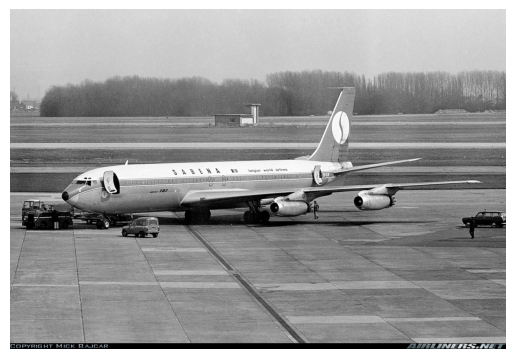


IMAGE DESCRIPTION:
douglas dc-8,boeing 2707,sud aviation caravelle,boeing 707,lockheed l-100 hercule

MODEL_RESPONSE: 
A vintage Boeing 747 is parked on the tarmac with ground support vehicles nearby.


In [15]:
id = 0

image = filtered_test_dataset[id]["image"].convert("RGB")
description = ",".join(filtered_test_dataset[id]['clip_tags_ViT_L_14'])

userPrompt = "Generate a concise caption for this image, mentioning specific airplane types:"
messages = [
    {"role": "user", "content": f"<|image_1|>\n{userPrompt}"}
]

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(prompt, [image], return_tensors="pt").to(device)

generation_args = {
    "max_new_tokens": 100,
    "temperature": 0.9
}

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]
response = processor.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

plt.imshow(image)
plt.axis("off")
plt.show()

print(f"\nIMAGE DESCRIPTION:\n{description}")
print(f"\nMODEL_RESPONSE: \n{response}")

The base model provides a general response to the image, which can be seen in the generated caption. However, this response has several limitations when it comes to the precise identification of specific airplane types and relevant details.

# 5. Fine-tuning

## 5.1 Prepare Dataset

Let's prepare train dataset, val dataset and test dataset. We will split the `filtered_train_dataset` into train set and val set. 

In [16]:
split_dataset = filtered_train_dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# train_dataset = filtered_train_dataset
test_dataset = filtered_test_dataset

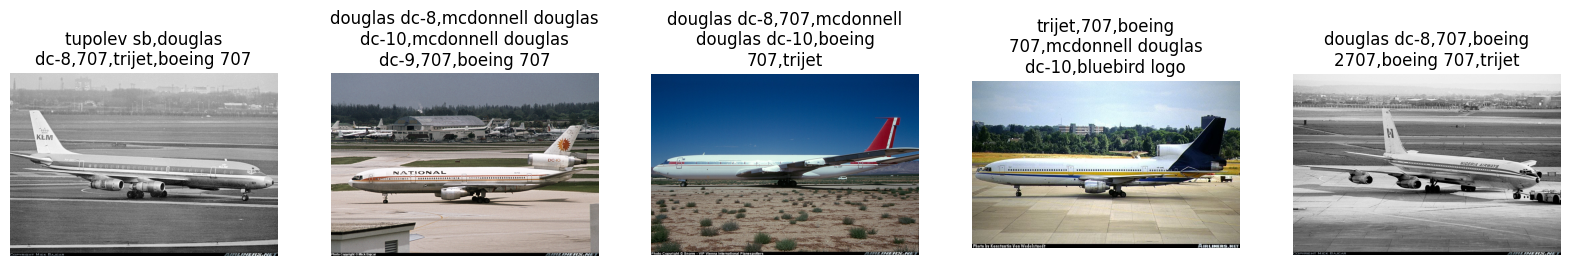

In [17]:
# Code taken from https://huggingface.co/docs/transformers/main/en/tasks/image_captioning
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(",".join(caption), 30))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

sample_images_to_visualize = [np.array(train_dataset[i]["image"]) for i in range(5)]
sample_captions = [train_dataset[i]["clip_tags_ViT_L_14"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## 5.2 Setup DataCollator

Now let's define the data collator. It handles the batching and preprocessing of input data, and it prepares the input prompts and corresponding labels, ensuring they are correctly formatted and tokenized for the model. By customizing the DataCollator, we can efficiently manage complex data structures and input-output relationships required for our multi-modal fine-tuning task. This setup is crucial for creating consistent and coherent batches during training and evaluation.

In [18]:
IGNORE_INDEX = -100

def pad_sequence(sequences, padding_side='right', padding_value=0):
    """
    Pad a list of sequences to the same length.
    sequences: list of tensors in [seq_len, *] shape
    """
    assert padding_side in ['right', 'left']
    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max(len(seq) for seq in sequences)
    batch_size = len(sequences)
    output = sequences[0].new_full((batch_size, max_len) + trailing_dims, padding_value)
    for i, seq in enumerate(sequences):
        length = seq.size(0)
        if padding_side == 'right':
            output.data[i, :length] = seq
        else:
            output.data[i, -length:] = seq
    return output


class Phi3VDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def _get_inputs(self, user_prompt, image):
        images = [image]

        prompt_message = {'role': 'user', 'content': f'<|image_1|>\n{user_prompt}'}
        prompt = self.processor.tokenizer.apply_chat_template(
            [prompt_message], tokenize=False, add_generation_prompt=True
        )
        inputs = self.processor(prompt, images, return_tensors='pt')
        return inputs

    def __getitem__(self, idx):
        example = self.dataset[idx]

        all_input_ids = []
        all_labels = []
        all_pixel_values = []
        all_image_sizes = []
        user_prompt = "Generate a concise caption for this image, mentioning specific airplane types"
        for turn in [example]:
            inputs = self._get_inputs(user_prompt, turn['image'])
            prompt_input_ids = inputs['input_ids']

            answer = ",".join(example["clip_tags_ViT_L_14"])
            response = f'{answer}<|end|>\n<|endoftext|>'
            
            # Do not add bos token to answer
            response_input_ids = self.processor.tokenizer(
                response, add_special_tokens=False, return_tensors='pt'
            )['input_ids']

            input_ids = torch.cat([prompt_input_ids, response_input_ids], dim=1).squeeze(0)
            labels = torch.cat(
                [
                    torch.tensor([IGNORE_INDEX] * len(prompt_input_ids[0])),
                    response_input_ids.squeeze(0),
                ],
                dim=0,
            )

            all_input_ids.append(input_ids)
            all_labels.append(labels)
            all_pixel_values.append(inputs['pixel_values'])
            all_image_sizes.append(inputs['image_sizes'])

        input_ids = torch.cat(all_input_ids, dim=0)
        labels = torch.cat(all_labels, dim=0)
        pixel_values = torch.cat(all_pixel_values, dim=0)
        image_sizes = torch.cat(all_image_sizes, dim=0)

        return {
            # 'id': example['id'],  # unique identifier for the example
            'input_ids': input_ids,
            'labels': labels,
            'pixel_values': pixel_values,
            'image_sizes': image_sizes,
        }


class Phi3VDataCollator:
    def __init__(self, pad_token_id: int):
        self.pad_token_id = pad_token_id

    def __call__(self, examples):
        batch_input_ids = []
        batch_label_ids = []
        batch_pixel_values = []
        batch_image_sizes = []
        for example in examples:
            batch_input_ids.append(example['input_ids'])
            batch_pixel_values.append(example['pixel_values'])
            batch_image_sizes.append(example['image_sizes'])
            batch_label_ids.append(example['labels'])

        input_ids = pad_sequence(
            batch_input_ids, padding_side='right', padding_value=self.pad_token_id
        )
        attention_mask = input_ids != self.pad_token_id
        labels = pad_sequence(batch_label_ids, padding_side='right', padding_value=IGNORE_INDEX)
        pixel_values = torch.cat(batch_pixel_values, dim=0)
        image_sizes = torch.cat(batch_image_sizes, dim=0)

        batch = {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'pixel_values': pixel_values,
            'image_sizes': image_sizes,
        }
        
        for key, value in batch.items():
            if isinstance(value, torch.Tensor) and torch.is_floating_point(value):
                batch[key] = value.clone().detach().requires_grad_(True)
                
        return batch

We will use `data_collator` to setup datasets for training. 

In [19]:
data_collator = Phi3VDataCollator(processor.tokenizer.pad_token_id)
train_dataset = Phi3VDataset(train_dataset, processor)
val_dataset = Phi3VDataset(val_dataset, processor)

In [20]:
examples = [train_dataset[i] for i in range(2)]
collator_output = data_collator(examples)
print(collator_output.keys())

dict_keys(['input_ids', 'labels', 'attention_mask', 'pixel_values', 'image_sizes'])


## 5.3 Setup LoRA

Next, we will prepare the model for fine-tuning with LoRA (Low-Rank Adaptation). LoRA is a technique used to efficiently fine-tune transformer models by introducing trainable low-rank linear layers into the target layers of the model. This approach reduces the number of parameters that need to be updated during training, making the process more memory-efficient and faster.

We will apply LoRA specifically to the attention mechanisms and feed-forward operations of the model. The modules related to attention mechanisms and feed-forward operations are then specified in the LoRA configuration, ensuring that the fine-tuning process is focused on these components.

In [21]:
## prepare model from training
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
model.resize_token_embeddings(len(processor.tokenizer))

Embedding(32045, 3072, padding_idx=32000)

In [22]:
target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"]

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj.weight",
        "self_attn.k_proj.weight",
        "self_attn.v_proj.weight",
        "self_attn.qkv_proj.weight",
        "self_attn.out_proj.weight",
        "mlp.gate_up_proj",
        "mlp.down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    use_dora=False
)

peft_model = get_peft_model(model, lora_config)

train_dataset.start_iteration = 0

With Lora, we have limited trainable weights.Enhence it allows for efficient fine-tuning of large language models, making it a practical choice for scenarios where full model training might not be feasible due to resource constraints.

In [23]:
peft_model.print_trainable_parameters()

trainable params: 15,728,640 || all params: 4,162,233,344 || trainable%: 0.3779


This is because you've specified will be the ones affected by the Lora adaptation, while the rest of the model's weights remain frozen. You can take a look at the network with adapted layers of this model have for training:

In [24]:
peft_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Phi3VForCausalLM(
      (model): Phi3VModel(
        (embed_tokens): Embedding(32045, 3072, padding_idx=32000)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (vision_embed_tokens): Phi3ImageEmbedding(
          (drop): Dropout(p=0.0, inplace=False)
          (wte): Embedding(32045, 3072, padding_idx=32000)
          (img_processor): CLIPVisionModel(
            (vision_model): CLIPVisionTransformer(
              (embeddings): CLIPVisionEmbeddings(
                (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
                (position_embedding): Embedding(577, 1024)
              )
              (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (encoder): CLIPEncoder(
                (layers): ModuleList(
                  (0-23): 24 x CLIPEncoderLayer(
                    (self_attn): CLIPSdpaAttention(
                      (k_proj)

## 5.4 Training

To prepare for model training using the `transformers.Trainer` API, you need to set up the training parameters. These parameters will guide the fine-tuning process to get the best model:  

In [25]:
training_args = transformers.TrainingArguments(
    num_train_epochs=4,                         # Number of training epochs
    per_device_train_batch_size=batch_size,      # Batch size for training
    per_device_eval_batch_size=batch_size,       # Batch size for evaluation
    gradient_accumulation_steps=2,               # Number of steps to accumulate gradients before updating
    gradient_checkpointing=True,                 # Enable gradient checkpointing to save memory
    do_eval=True,                                # Perform evaluation during training
    save_total_limit=2,                          # Limit the total number of saved checkpoints
    evaluation_strategy="steps",                 # Evaluation strategy to use (here, at each specified number of steps)
    save_strategy="steps",                       # Save checkpoints at each specified number of steps
    save_steps=10,                               # Number of steps between each checkpoint save
    eval_steps=10,                               # Number of steps between each evaluation
    max_grad_norm=1,                             # Maximum gradient norm for clipping
    warmup_ratio=0.1,                            # Warmup ratio for learning rate schedule
    weight_decay=0.001,                          # Regularization technique to prevent overfitting
    # fp16=True,                                 # Enable mixed precision training with fp16 (enable it if Ampere architecture is unavailable)
    bf16=True,                                   # Enable mixed precision training with bf16
    logging_steps=10,                            # Number of steps between each log
    output_dir="outputs",                        # Directory to save the model outputs and checkpoints
    optim="adamw_torch",                         # Optimizer to use (AdamW with PyTorch)
    learning_rate=5e-5,                          # Learning rate for the optimizer
    lr_scheduler_type="linear",                  # Learning rate scheduler type: constant
    load_best_model_at_end=True,                 # Load the best model found during training at the end
    metric_for_best_model="rouge",               # Metric used to determine the best model
    greater_is_better=True,                      # Indicates if a higher metric score is better
    push_to_hub=False,                           # Whether to push the model to Hugging Face Hub
    run_name="phi-3-5-vision-finetuning-eval",   # Name of the run for experiment tracking
    report_to="wandb"                            # For experiment tracking (login to Weights & Biases needed)
)

Rouge is a set of metrics used for evaluating NLP tasks. This is a simple example, it takes as input a list of predictions and a list of references:

In [26]:
rouge = evaluate.load("rouge")
predictions = ["A large commercial airplane with a blue tail and a red logo, possibly a Qantas Boeing 747, is taking off from an airport runway."]
references = ["tupolev sb,707,boeing 707,douglas dc-8,boeing 2707"]

rouge_score = rouge.compute(predictions=predictions, references=references)
print(rouge_score)

{'rouge1': 0.058823529411764705, 'rouge2': 0.0, 'rougeL': 0.058823529411764705, 'rougeLsum': 0.058823529411764705}


Let's setup the our customized trainer with training dataloader.

In [27]:
class CustomTrainer(transformers.Trainer):
    def get_train_dataloader(self):
        # Ensure the DataLoader uses your custom DataCollator
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )
    
    def get_eval_dataloader(self, eval_dataset=None):
        # Ensure the DataLoader uses your custom DataCollator for evaluation
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        return DataLoader(
            eval_dataset,
            batch_size=self.args.eval_batch_size,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    rouge_scores = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
    rouge1_score = rouge_scores["rouge1"]
    return {"rouge": rouge1_score}

# Ensure the model is in training mode
peft_model.train()

trainer = CustomTrainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

peft_model.config.use_cache = False

Now, it's just the time to train our model.

In [28]:
trainer.train()

[2024-11-16 13:08:46,478] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/anaconda/envs/azureml_py38_PT_TF/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


Step,Training Loss,Validation Loss,Rouge
10,3.004500,2.462729,0.016625


TrainOutput(global_step=16, training_loss=2.8139270544052124, metrics={'train_runtime': 48.4344, 'train_samples_per_second': 1.321, 'train_steps_per_second': 0.33, 'total_flos': 1288197009162240.0, 'train_loss': 2.8139270544052124, 'epoch': 4.0})

After training, we will save the model for inference

In [29]:
trainer.save_model(model_dir)
processor.tokenizer.save_pretrained(model_dir)

('models/peft_adapter/tokenizer_config.json',
 'models/peft_adapter/special_tokens_map.json',
 'models/peft_adapter/tokenizer.json')

Clean up the mem

In [30]:
del model
del processor
del peft_model

# 6. Inference with Finetuned Model

Let's do inference with the fine tuning model and start with load saved model in the training.

In [31]:
def load_with_peft_adapter(base_model_id, model_path, device="auto", dtype=torch.bfloat16):
    """
        load model via Huggingface AutoModelForCausalLM and AutoProcessor
    """
    torch.set_default_device(device)

    with torch.device(device):

        processor = transformers.AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

        model = transformers.AutoModelForCausalLM.from_pretrained(
            base_model_id,
            device_map=device,
            torch_dtype=dtype,
            trust_remote_code=True,
            use_flash_attention_2=False,
            _attn_implementation="eager"
        ).eval()

        model.resize_token_embeddings(len(processor.tokenizer))

        finetuned_model = PeftModel.from_pretrained(
            model,
            model_path
        ).eval()
        finetuned_model.to(device)
        finetuned_model.config.use_cache = True

        return finetuned_model, processor, model

finetuned_model, processor, model = load_with_peft_adapter(base_model_id, model_dir, device="cuda", dtype=dtype)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


We will plot the image and test with one image from test dataset.


PROMPT: 
<|user|>
<|image_1|>
Generate a concise caption for this image, mentioning specific airplane types<|end|>
<|assistant|>



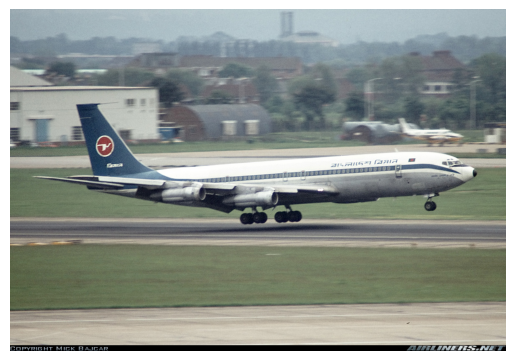

MODEL RESPONSE: A large commercial airliner, likely a Boeing 747, is captured in the midst of landing, with its landing gear extended and flaps deployed for slowing down.
EXPECTED RESPONSE: tupolev sb,707,boeing 707,douglas dc-8,boeing 2707


In [32]:
def inference_with_finetuned_model(finetuned_model, processor, tokenizer, image, device="auto", temperature = 0.0):
  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"

  prompt = f"<|user|>\n<|image_1|>\n{userPrompt}<|end|>\n<|assistant|>\n"

  print(f"\nPROMPT: \n{prompt}")

  plt.imshow(image)
  plt.axis("off")
  plt.show()

  inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

  generation_args = {
      "max_new_tokens": 128,
      "temperature": 0.0
  }

  with torch.no_grad():
    generate_ids = finetuned_model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]

  decoded_output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  response = decoded_output[0]

  return response


id = 1

image = filtered_test_dataset[id]["image"].convert("RGB")
description = ",".join(filtered_test_dataset[id]["clip_tags_ViT_L_14"])

response = inference_with_finetuned_model(finetuned_model, processor, processor.tokenizer, image, device)
print(f"MODEL RESPONSE: {response}")
print(f"EXPECTED RESPONSE: {description}")

# 7. Testing

Let's continue to test with base model and LoRA fine tuned model and compare the results.

In [33]:
def inference_with_base_model(id, dataset):
  image = dataset[id]["image"].convert("RGB")

  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"
  messages = [
      {"role": "user", "content": f"<|image_1|>\n{userPrompt}"}
  ]

  prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  inputs = processor(prompt, [image], return_tensors="pt").to(device)

  generation_args = {
      "max_new_tokens": 512,
      "temperature": 0.0
  }

  generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]
  response = processor.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

  return response


def inference_with_finetuned_model(id, dataset, finetuned_model, processor, tokenizer, device="auto", temperature = 0.0):
  image = dataset[id]["image"].convert("RGB")

  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"

  prompt = f"<|user|>\n<|image_1|>\n{userPrompt}<|end|>\n<|assistant|>\n"

  inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

  generation_args = {
      "max_new_tokens": 128,
      "temperature": 0.0
  }

  with torch.no_grad():
    generate_ids = finetuned_model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]

  decoded_output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  response = decoded_output[0]

  return response

In [34]:
images_to_visualize = [np.array(test_dataset[i]["image"]) for i in range(5)] #len(test_dataset)
expected_captions = [test_dataset[i]["clip_tags_ViT_L_14"] for i in range(5)]
base_model_captions = [inference_with_base_model(i, test_dataset) for i in range(5)]
finetuned_model_captions = [inference_with_finetuned_model(i, test_dataset, finetuned_model, processor, processor.tokenizer) for i in range(5)]

In [35]:
def plot_images(images, expected_captions, model_captions, model_captions_color="red"):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)

        expected_caption = expected_captions[i]
        expected_caption = "\n".join(wrap(",".join(expected_caption), 30))

        model_caption = model_captions[i]
        model_caption = "\n".join(wrap(model_caption, 30))

        plt.title(expected_caption, color="green", fontsize=12)
        plt.xlabel(model_caption, color=model_captions_color, fontsize=10, labelpad=20)

        plt.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

We will plot images and results with inference of base model.

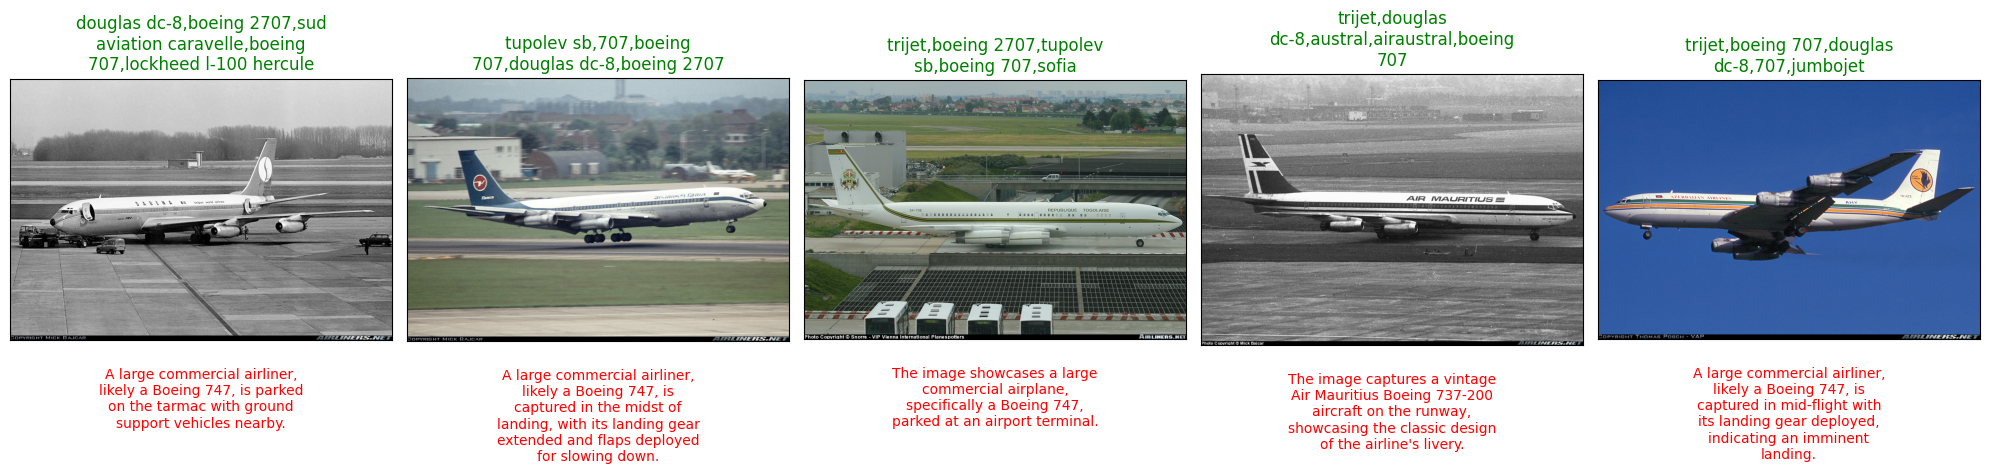

In [36]:
plot_images(images_to_visualize, expected_captions, base_model_captions)

And now well will plot images and results with our fine tuned model.

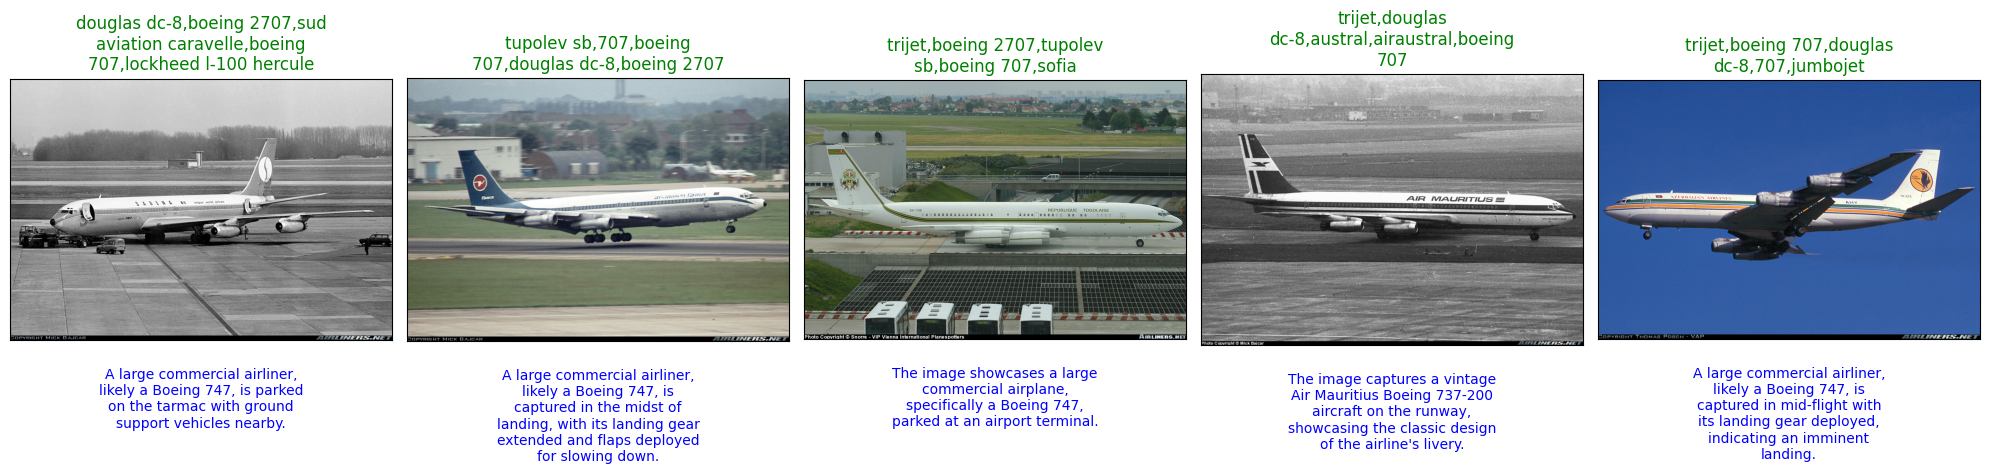

In [37]:
plot_images(images_to_visualize, expected_captions, finetuned_model_captions, "blue")

Now let's compute the rouge scores to see how better it has imporved.

In [38]:
expected_captions_formatted = [",".join(c) for c in expected_captions]
base_rouge_score = rouge.compute(predictions=expected_captions_formatted, references=base_model_captions)
fintuned_rouge_score = rouge.compute(predictions=expected_captions_formatted, references=finetuned_model_captions)

print(base_rouge_score)
print(fintuned_rouge_score)

{'rouge1': 0.06651433691756273, 'rouge2': 0.0, 'rougeL': 0.06651433691756273, 'rougeLsum': 0.0661111111111111}
{'rouge1': 0.06651433691756273, 'rouge2': 0.0, 'rougeL': 0.06651433691756273, 'rougeLsum': 0.0661111111111111}


## 7. Further exploration

### 7.1 Fine tuning with flash attention 2 + LoRA
With better GPU architecture, you can fine tune your model with Flash Attention 2 with the following change when load your model and set `use_flash_attention_2=True`. 
```Python
# Initialize model
model = transformers.AutoModelForCausalLM.from_pretrained(
          base_model_id, 
          torch_dtype= dtype, ## torch.bfloat16, 
          trust_remote_code=True, 
          use_flash_attention_2=True,
).to(device)
```

Note, QLoRA is not gracfully supported now. You can move the next section to see how to do with QLoRA with a workaround.

### 7.2 Fine tuning with flash attention 2 + QLoRA

Wtih quantization, the `transformers` `Trainer` does not work properly when training and sometimes goes with an error `RuntimeError: FlashAttention only support fp16 and bf16 data type`. You can refer to a similiar problem here: 
https://huggingface.co/microsoft/Phi-3-small-8k-instruct/discussions/11#6659a17e8b11da966e8e510c

If this error happens, the work around is to munually convert the qkv results to the targeted type when doing image embeddings.

You can add convertion logic in `modeling_phi3_v.py` 

```python
query_states = query_states.to(your_targeted_type)
key_states = key_states.to(your_targeted_type)
value_states = value_states.to(your_targeted_type)
```
In this example, we use torch.float16 for training. You can convert to torch.float16 manually. Here's the changed code as a workaround

```python
class CLIPAttentionFA2(CLIPAttention):
    """Add flash attention 2 to CLIPAttention. (This is only used in the vision encoder)"""

    def forward(self,
        hidden_states,
        attention_mask=None,
        causal_attention_mask=None,
        output_attentions=False,
    ):
        """Input shape: Batch x Time x Channel"""

        assert attention_mask is None, "CLIPAttentionFA2 does not support attention_mask"
        assert causal_attention_mask is None, "CLIPAttentionFA2 does not support causal_attention_mask"
        assert output_attentions is False, "CLIPAttentionFA2 does not support output_attentions"

        bsz, tgt_len, embed_dim = hidden_states.size()
        query_states = self.q_proj(hidden_states).reshape(bsz, tgt_len, self.num_heads, self.head_dim)
        key_states = self.k_proj(hidden_states).reshape(bsz, tgt_len, self.num_heads, self.head_dim)
        value_states = self.v_proj(hidden_states).reshape(bsz, tgt_len, self.num_heads, self.head_dim)

        query_states = query_states.to(torch.float16)
        key_states = key_states.to(torch.float16)
        value_states = value_states.to(torch.float16)
        
        attn_output = flash_attn_func(
            query_states,
            key_states,
            value_states,
            dropout_p=self.dropout if self.training else 0.0,
            softmax_scale=self.scale,
            causal=False,
        ).reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)
        return attn_output, None
```

Then you can go with QLoRA with model initialized by the following code:
```python
# Initialize model
bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
)

model = transformers.AutoModelForCausalLM.from_pretrained(
          base_model_id, 
          torch_dtype= dtype, ## torch.bfloat16, 
          trust_remote_code=True, 
          quantization_config=bnb_config,
          use_flash_attention_2=True
).to(device)
```